In [135]:
import os
from glob import glob
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as gfg 
from lxml import etree
import wave
import numpy as np
from scipy.io import wavfile
from scipy import signal
import scipy.io
from scipy.fftpack import fft
import os


In [136]:
def readcsv(path):
    df = pd.read_csv(path)
    df = normalization(df,1000)
    return df

In [137]:
# Frequency_Response
# 繪製單一頻響圖型
def plot_Raw(Raw,xfig,yfig,file_path):
    #fig = plt.figure(figsize=(20, 10))
    plt.plot(Raw.frequency, Raw.raw, label="Raw", color='gray', alpha=1)
    plt.semilogx()
    plt.legend()
    plt.grid()
    plt.xlabel("frequencyuency")
    plt.ylabel("Amplitude")
    if file_path is not None:
        #file_path = os.path.abspath(file_path)
        plt.savefig(file_path+"Single FR Plot.png",dpi=600)
        print("Have save fig into "+"Single FR Plot.png")

# 繪製雙頻響圖型與兩者誤差
def plot_TargetRaw(Raw,Target,xfig,yfig,file_path):
    fig = plt.figure(figsize=(xfig, yfig))
    plt.plot(Raw.frequency, Raw.raw, label="Raw", color='gray', alpha=1)
    plt.plot(Target.frequency, Target.raw, label="Target", color='#0072BD', alpha=1)
    if(Raw.shape[0]!=Target.shape[0]):
        plt.plot(Target.frequency, Raw.raw-Target.raw, label="error", color='brown', alpha=0.5)
        print("Shape different")
    plt.semilogx()
    plt.legend()
    plt.grid()
    plt.xlabel("frequencyuency")
    plt.ylabel("Amplitude")
    if file_path is not None:
        #file_path = os.path.abspath(file_path)
        plt.savefig(file_path+"Compare FR Plot.png",dpi=600)
        print("Have save fig into "+"Compare FR Plot.png")

# 繪製虛擬耳機之相關參數
def plot_Equalization(Raw,Target,Equalization,xfig,yfig,file_path):
    fig = plt.figure(figsize=(xfig, yfig))
    plt.plot(Raw.frequency, Raw.raw, label="Raw", color='gray')
    plt.plot(Target.frequency, Raw.raw-Target.raw, label="Error", color='brown')
    plt.plot(Equalization.frequency, Equalization.raw,label='LimitEqualization', linewidth=5, color='lightgreen',alpha=0.5)
    plt.plot(Target.frequency, Target.raw-Raw.raw, label="Equalization", color='green')
    plt.plot(Equalization.frequency, Equalization.raw+Raw.raw, label="Equalized", linewidth=5, color='lightblue',alpha=0.5)
    plt.plot(Target.frequency, Target.raw, label="Target", linewidth=1, color='steelblue')
    plt.semilogx()
    plt.legend()
    plt.grid()
    plt.xlabel("frequencyuency")
    plt.ylabel("Amplitude")
    if file_path is not None:
            #file_path = os.path.abspath(file_path)
            plt.savefig(file_path+"Equalization FR Plot.png",dpi=600)
            print("Have save fig into "+"Equalization FR Plot.png")
# 正規化誤差
def normalization(df,freq):
    error = 100000
    for i in range(df.shape[0]):
        tfreq = df.frequency[i]
        tmp = abs(freq - tfreq)
        if(tmp<error):
            error = tmp
            noramlization = i
    error = 0 - df.raw[noramlization]
    df.raw = df.raw + error
    #最近與標準之誤差值
    #print("最近與標準之原誤差值 = ",error)
    #最近與標準誤差值之index
    #print("最近與標準誤差值之index = ",noramlization)
    #最近與標準誤差值之數值
    #print("正規化後數據",df.frequency[noramlization],df.raw[noramlization])
    return df

#Calculate Equalization
def Equalize(raw,target):
    #Target - raw
    Equalization = target.raw-raw.raw
    Equalization
    Equalization = pd.DataFrame({"frequency":raw.frequency,"raw":Equalization})
    return Equalization

# 耳機最大raw限制
def limitation(df,limit):
    for i in range(df.shape[0]):
        if(df.raw[i]>limit):
            df.raw[i]=limit
    return df

# Audacity limit
# Audacity自動匯入系統限制為200plot
# 將特徵點減少至1/4以便使用Audacity自動匯入系統
def Smooth(df,num):
    sdf = pd.DataFrame({"frequency":[],"raw":[]})
    for i in range(df.shape[0]):
        if(i%int(num)==0):
            add = {'frequency': df.frequency[i], 'raw': df.raw[i]}
            sdf = sdf.append(add, ignore_index = True)
    return sdf

def virtualization(raw,target,limit):
    Equalization = Equalize(raw,target)
    Equalization = limitation(Equalization,limit)
    if(raw.shape[0]>200):
        num = int(raw.shape[0]/200)
        if((raw.shape[0]/num)>200):
            num+=1
        #print(num)
        #Equalization = Smooth(Equalization,num)
    return Equalization


In [138]:
# Octave_Transfer
octave_24 = [20.0,20.6,21.2,21.8,22.4,23.0,23.6,24.3,25.0,25.8,26.5,27.2,28.0,29.0,30.0,30.7,31.5,32.5,33.5,34.5,35.5,36.5,37.5,38.7,40.0,41.2,42.5,43.7,45.0,46.2,47.5,48.7,50.0,51.5,53.0,54.5,56.0,58.0,60.0,61.5,63.0,65.0,67.0,69.0,71.0,73.0,75.0,77.5,80.0,82.5,85.0,87.5,90.0,92.5,95.0,97.5,100.0,103.0,106.0,109.0,112.0,115.0,118.0,122.0,125.0,128.0,132.0,136.0,140.0,145.0,150.0,155.0,160.0,165.0,170.0,175.0,180.0,185.0,190.0,195.0,200.0,206.0,212.0,218.0,224.0,230.0,236.0,243.0,250.0,258.0,265.0,272.0,280.0,290.0,300.0,307.0,315.0,325.0,335.0,345.0,355.0,365.0,375.0,387.0,400.0,412.0,425.0,437.0,450.0,462.0,475.0,487.0,500.0,515.0,530.0,545.0,560.0,580.0,600.0,615.0,630.0,650.0,670.0,690.0,710.0,730.0,750.0,775.0,800.0,825.0,850.0,875.0,900.0,925.0,950.0,975.0,1000.0,1030.0,1060.0,1090.0,1120.0,1150.0,1180.0,1220.0,1250.0,1280.0,1320.0,1360.0,1400.0,1450.0,1500.0,1550.0,1600.0,1650.0,1700.0,1750.0,1800.0,1850.0,1900.0,1950.0,2000.0,2060.0,2120.0,2180.0,2240.0,2300.0,2360.0,2430.0,2500.0,2580.0,2650.0,2720.0,2800.0,2900.0,3000.0,3070.0,3150.0,3250.0,3350.0,3450.0,3550.0,3650.0,3750.0,3870.0,4000.0,4120.0,4250.0,4370.0,4500.0,4620.0,4750.0,4870.0,5000.0,5150.0,5300.0,5450.0,5600.0,5800.0,6000.0,6150.0,6300.0,6500.0,6700.0,6900.0,7100.0,7300.0,7500.0,7750.0,8000.0,8250.0,8500.0,8750.0,9000.0,9250.0,9500.0,9750.0,10000.0,10300.0,10600.0,10900.0,11200.0,11500.0,11800.0,12200.0,12500.0,12800.0,13200.0,13600.0,14000.0,14500.0,15000.0,15500.0,16000.0,16500.0,17000.0,17500.0,18000.0,18500.0,19000.0,19500.0,20000.0]
octave_12 = [20.0,21.2,22.4,23.6,25.0,26.5,28.0,30.0,31.5,33.5,35.5,37.5,40.0,42.5,45.0,47.5,50.0,53.0,56.0,60.0,63.0,67.0,71.0,75.0,80.0,85.0,90.0,95.0,100.0,106.0,112.0,118.0,125.0,132.0,140.0,150.0,160.0,170.0,180.0,190.0,200.0,212.0,224.0,236.0,250.0,265.0,280.0,300.0,315.0,335.0,355.0,375.0,400.0,425.0,450.0,475.0,500.0,530.0,560.0,600.0,630.0,670.0,710.0,750.0,800.0,850.0,900.0,950.0,1000.0,1060.0,1120.0,1180.0,1250.0,1320.0,1400.0,1500.0,1600.0,1700.0,1800.0,1900.0,2000.0,2120.0,2240.0,2360.0,2500.0,2650.0,2800.0,3000.0,3150.0,3350.0,3550.0,3750.0,4000.0,4250.0,4500.0,4750.0,5000.0,5300.0,5600.0,6000.0,6300.0,6700.0,7100.0,7500.0,8000.0,8500.0,9000.0,9500.0,10000.0,10600.0,11200.0,11800.0,12500.0,13200.0,14000.0,15000.0,16000.0,17000.0,18000.0,19000.0,20000.0]
octave_06 = [20.0,22.4,25.0,28.0,31.5,35.5,40.0,45.0,50.0,56.0,63.0,71.0,80.0,90.0,100.0,112.0,125.0,140.0,160.0,180.0,200.0,224.0,250.0,280.0,315.0,355.0,400.0,450.0,500.0,560.0,630.0,710.0,800.0,900.0,1000.0,1120.0,1250.0,1400.0,1600.0,1800.0,2000.0,2240.0,2500.0,2800.0,3150.0,3550.0,4000.0,4500.0,5000.0,5600.0,6300.0,7100.0,8000.0,9000.0,10000.0,11200.0,12500.0,14000.0,16000.0,18000.0,20000.0]
def rangeselect(df):
    df_new = []
    for i in range (len(df)):
        if(df[i]>=20 and df[i]<=20000):
            df_new.append(df[i])
    return df_new
def round_v2(num, decimal):
    num = np.round(num, decimal)
    num = float(num)
    return num
def _octave24(df,octave_24):
    df_freq = []
    df_gain = []
    for i in range (len(octave_24)):
        tmp = []
        tmpn = 0
        for j in range (len(df)):
            if(i==0):
                if(df.frequency[j]==octave_24[i]):
                    tmp.append(df.raw[j])
            elif(i>0 and i<len(octave_24)-1):
                if(df.frequency[j]<octave_24[i+1] and df.frequency[j]>octave_24[i-1]):
                    tmp.append(df.raw[j])
            elif(i==len(octave_24)-1):
                if(df.frequency[j]>octave_24[i-1]):
                    tmp.append(df.raw[j])
        
        for n in range (len(tmp)):
            tmpn = tmpn+tmp[n]
        if(tmpn!=0):
            mean = tmpn/len(tmp)
        else:
            mean = 0

        df_freq.append(octave_24[i])
        df_gain.append(mean)
        dfnew = pd.DataFrame({'frequency':df_freq,'raw':df_gain})
    return dfnew
def _octave12(df,octave):
    df_freq = []
    df_gain = []
    for i in range (len(octave)):
        tmp = []
        tmpn = 0
        for j in range (len(df)):
            if(i==0):
                if(df.frequency[j]==octave[i]):
                    tmp.append(df.raw[j])
            elif(i>0 and i<len(octave)-1):
                if(df.frequency[j]<octave[i+1] and df.frequency[j]>octave[i-1]):
                    tmp.append(df.raw[j])
            elif(i==len(octave)-1):
                if(df.frequency[j]>octave[i-1]):
                    tmp.append(df.raw[j])
        
        for n in range (len(tmp)):
            tmpn = tmpn+tmp[n]
        if(tmpn!=0):
            mean = tmpn/len(tmp)
            mean = round_v2(mean,2)
        else:
            mean = 0

        df_freq.append(octave[i])
        df_gain.append(mean)
        dfnew = pd.DataFrame({'frequency':df_freq,'raw':df_gain})
    return dfnew

In [139]:
# Equalization_Audacity
# XML maker and prettier
def prettyPrintXml(file_path):
    assert file_path is not None
    file_path = file_path+"Audacity_config.xml"
    parser = etree.XMLParser(resolve_entities=False, strip_cdata=False)
    document = etree.parse(file_path, parser)
    document.write(file_path, pretty_print=True, encoding='utf-8')
def GenerateXML(file_path,xml_f,xml_g) :
    root = gfg.Element("equalizationeffect")
    m1 = gfg.Element("curve", name="xba-h3(16k)20210914")
    root.append (m1)
    #b1 = gfg.SubElement(m1, "curve", name="xba-h3(16k)20210914")
    for i in range(len(xml_f)):
        gfg.SubElement(m1, "point", f=xml_f[i],d=xml_g[i])
    tree = gfg.ElementTree(root)
    file_path = file_path+"Audacity_config.xml"
    with open (file_path, "wb") as files :
        tree.write(files)
    print("Have save xml into "+file_path)
# TXT maker
def GemerateTXT(dicf,dicv,file_path):
    freqLine = ""
    valueLine = ""
    for i in range(len(dicf)):
        for j in range(len(dicf[i])):
            freqLine=freqLine+dicf[i][j]
            valueLine=valueLine+dicv[i][j]
    audacityLine = '''FilterCurve: {freqLine}FilterLength="8191" InterpolateLin="0" InterpolationMethod="B-spline" {valueLine}'''.format(freqLine=freqLine,valueLine=valueLine)
    #print(audacityLine)
    file_path = file_path+"Audacity_config.txt"
    f = open(file_path, 'w')
    f.writelines(audacityLine)
    f.close()
    print("Have save txt into "+file_path)

In [140]:
# WAV_Plot
# 讀取音檔，可讀取 16bits 以上
def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result

def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array
import numpy
def frget(samplingFreq,mySound):
    #Check if wave file is 16bit or 32 bit. 24bit is not supported
    #檢查波形文件是16位還是32位。 不支持 24 位
    mySoundDataType = mySound.dtype

    #We can convert our sound array to floating point values ranging from -1 to 1 as follows
    #我們可以將我們的聲音數組轉換為範圍從 -1 到 1 的浮點值，如下所示
    mySound = mySound / (2.**15)

    #Check sample points and sound channel for duel channel(5060, 2) or  (5060, ) for mono channel
    #檢查雙聲道(5060, 2)或(5060, )單聲道的採樣點和聲道
    mySoundShape = mySound.shape
    samplePoints = float(mySound.shape[0])

    #Get duration of sound file
    #獲取聲音文件的時長
    signalDuration =  mySound.shape[0] / samplingFreq

    #If two channels, then select only one channel
    #如果有兩個通道，則只選擇一個通道
    mySoundOneChannel = mySound[:,0]

    #Plotting the tone
    #繪製基調
    # We can represent sound by plotting the pressure values against time axis.
    #Create an array of sample point in one dimension
    # 我們可以通過根據時間軸繪製壓力值來表示聲音。
    #創建一維樣本點數組
    timeArray = numpy.arange(0, samplePoints, 1)

    #
    timeArray = timeArray / samplingFreq

    #Scale to milliSeconds
    #Scale到毫秒
    timeArray = timeArray * 1000

    #Plot the tone
    #繪製時域
    ########################################################################
    #plt.plot(timeArray, mySoundOneChannel, color='g')
    #plt.xlabel('Time (ms)')
    #plt.ylabel('Amplitude')
    #plt.show()
    ########################################################################


    #Plot frequency content
    #We can get frquency from amplitude and time using FFT , Fast Fourier Transform algorithm
    #繪製頻率內容
    #我們可以使用FFT，快速傅立葉變換算法從幅度和時間中獲得頻率

    #Get length of mySound object array
    #獲取mySound對像數組的長度
    mySoundLength = len(mySound)

    #Take the Fourier transformation on given sample point 
    #對給定的樣本點進行傅立葉變換
    #fftArray = fft(mySound)
    fftArray = fft(mySoundOneChannel)
    
    numUniquePoints = int(numpy.ceil((mySoundLength + 1) / 2.0))
    fftArray = fftArray[0:numUniquePoints]
    
    #FFT contains both magnitude and phase and given in complex numbers in real + imaginary parts (a + ib) format.
    #FFT 包含幅度和相位，並以實部 + 虛部 (a + ib) 格式以復數形式給出。
    
    #By taking absolute value , we get only real part
    #取絕對值，我們只得到實部

    fftArray = abs(fftArray)

    #Scale the fft array by length of sample points so that magnitude does not depend on
    #the length of the signal or on its sampling frequency
    #按樣本點的長度縮放fft數組，使幅度不依賴於信號的長度或其採樣頻率
    
    fftArray = fftArray / float(mySoundLength)

    #FFT has both positive and negative information. Square to get positive only
    #FFT既有正面信息也有負面信息。 方形只獲得正面
    fftArray = fftArray **2

    #Multiply by two (research why?)
    #Odd NFFT excludes Nyquist point
    if mySoundLength % 2 > 0: #we've got odd number of points in fft#我們在fft中有奇數個點
        fftArray[1:len(fftArray)] = fftArray[1:len(fftArray)] * 2

    else: #We've got even number of points in fft#我們在fft中有偶數個點
        fftArray[1:len(fftArray) -1] = fftArray[1:len(fftArray) -1] * 2  

    freqArray = numpy.arange(0, numUniquePoints, 1.0) * (samplingFreq / mySoundLength);
    return freqArray,fftArray
def TD_single(samplerate,data,xfig,yfig,file_path):
    print(f"number of samplerate = {samplerate}")
    print(f"number of channels = {data.shape[1]}")
    length = data.shape[0] / samplerate
    print(f"length = {length}s")

    time = np.linspace(0., length, data.shape[0])
    fig = plt.figure(figsize=(xfig, yfig))

    plt.plot(time, data[:, 0], label="Raw", color='gray')

    plt.xticks(range(int(length)))  # 設定x刻度


    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    #plt.show()
    
    if file_path is not None:
        #file_path = os.path.abspath(file_path)
        plt.savefig(file_path+"Wav_TD_single.png",dpi=600)
        print("Have save fig into "+file_path+"Wav_TD_single.png")
def TD_twice(samplerate,data,samplerate2,data2,xfig,yfig,file_path):
    print(f"number of samplerate = {samplerate}")
    print(f"number of channels = {data.shape[1]}")
    length = data.shape[0] / samplerate
    print(f"length = {length}s")
    time = np.linspace(0., length, data.shape[0])

    
    print(f"number of samplerate = {samplerate2}")
    print(f"number of channels = {data2.shape[1]}")
    length2 = data2.shape[0] / samplerate2
    print(f"length = {length2}s")
    time2 = np.linspace(0., length2, data2.shape[0])

    fig = plt.figure(figsize=(xfig, yfig))
    plt.plot(time, data[:, 0], label="Raw", color='gray')
    plt.plot(time2, data2[:, 0], label="Target", color='brown')
    #plt.plot(time, data[:, 1], label="Right channel")
    plt.xticks(range(int(length)))  # 設定x刻度


    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    #plt.show()
    if file_path is not None:
        #file_path = os.path.abspath(file_path)
        plt.savefig(file_path+"Wav_TD_twice.png",dpi=600)
        print("Have save fig into "+file_path+"Wav_TD_twice.png")
def FD_single(freqArray,fftArray,xfig,yfig,file_path):
    #Plot the frequency
    fig = plt.figure(figsize=(xfig, yfig))
    plt.plot(freqArray/1000, 10 * numpy.log10 (fftArray), color='gray')
    plt.xlabel('Frequency (Khz)')
    plt.ylabel('Power (dB)')
    
    #plt.show()

    if file_path is not None:
        #file_path = os.path.abspath(file_path)
        plt.savefig(file_path+"Wav_FD_single.png",dpi=600)
        print("Have save fig into "+file_path+"Wav_FD_single.png")
def FD_twice(freqArray,fftArray,freqArray2,fftArray2,xfig,yfig,file_path):
    #Plot the frequency
    fig = plt.figure(figsize=(xfig, yfig))
    plt.plot(freqArray/1000, 10 * numpy.log10 (fftArray), color='gray', label="Raw")
    plt.plot(freqArray2/1000, 10 * numpy.log10 (fftArray2), color='brown', label="Target")
    
    plt.legend()
    plt.xlabel('Frequency (Khz)')
    plt.ylabel('Power (dB)')
    #plt.show()

    #Get List of element in frequency array
    #print freqArray.dtype.type
    #freqArrayLength = len(freqArray)
    #print ("freqArrayLength =", freqArrayLength)
    #numpy.savetxt("freqData.txt", freqArray, fmt='%6.2f')

    #Print FFtarray information
    #print ("fftArray length =", len(fftArray))
    #numpy.savetxt("fftData.txt", fftArray)
    if file_path is not None:
        #file_path = os.path.abspath(file_path)
        plt.savefig(file_path+"Wav_FD_twice.png",dpi=600)
        print("Have save fig into "+file_path+"Wav_FD_twice.png")


In [172]:
def Octave_Transfer(Raw_csv,file_path,Virtualize):
    df = readcsv(Raw_csv)
    df = _octave24(df,octave_24)
    df = _octave12(df,octave_12)
    file_path = file_path+"octave12.csv"
    if(Virtualize):
        print("Octave_Transfer Complete")
    else:
        df.to_csv(file_path, index=False)
        print("Have save Octave_Transfer into "+file_path)
    return df

In [173]:
## Frequency_Response
def Frequency_Response(Raw_csv=None, file_path="./outputs/",Target_csv=None,multi=False,Virtualize=False,Limit=1000,xfig=6,yfig=4):
    if(multi):
        print("------Virtualize Script Start-----")
        
        Raw = (Raw_csv)
        Target = (Target_csv)
        result = virtualization(Raw,Target,Limit)
        plot_Equalization(Raw,Target,result,xfig,yfig,file_path)
        file_path = file_path+'Virtualize_filter.csv'
        result.to_csv(file_path, index=False)
        print("Have save csv into "+file_path)
        print("------Virtualize Script End-----")
        return result
    if(Virtualize and Target_csv):
        print("------Virtualize Script Start-----")
        Raw = readcsv(Raw_csv)
        Target = readcsv(Target_csv)
        result = virtualization(Raw,Target,Limit)
        plot_Equalization(Raw,Target,result,xfig,yfig,file_path)
        result.to_csv(file_path+'Virtualize_filter.csv', index=False)
        print("Have save csv into "+file_path+'Virtualize_filter.csv')
        print("------Virtualize Script End-----")
        return result
    elif(Target_csv):
        print("------Compare Plot------")
        Raw = readcsv(Raw_csv)
        Target = readcsv(Target_csv)
        plot_TargetRaw(Raw,Target,xfig,yfig,file_path)
        print("------Compare Plot-----")
    else:
        print("------Raw Plot------")
        Raw = readcsv(Raw_csv)
        plot_Raw(Raw,xfig,yfig,file_path)
        print("------Raw Plot------")

    

In [174]:
def Equalization_Audacity(Raw_csv=None,file_path="./output/",xml=False,multi=False):
    if(multi==True):
        df = (Raw_csv)
    else:
        df = readcsv(Raw_csv)
    tmpF = ""
    tmpV = ""
    classification =[1,2,3,4,5,6,7,8,9,0]
    dicf={1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],0:[]}
    dicv={1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],0:[]}
    num = 0 
    xml_f=[]
    xml_g=[]

    # 將依照equalization之欄位值去存取eq調整數值
    for i in range(df.shape[0]):
        tmpF = 'f'+str(num)+'="'+str(df['frequency'][i])+'" '
        tmpV = 'v'+str(num)+'="'+str(df['raw'][i])+'" '
        for j in range (len(classification)):
            if(str(num)[0]==str(classification[j])):
                dicf[classification[j]].append(tmpF)
                dicv[classification[j]].append(tmpV)
                # XML(舊版本)
                xml_f.append(str(df['frequency'][i]))
                xml_g.append(str(df['raw'][i]))
                num+=1
                break
    GemerateTXT(dicf,dicv,file_path)
    
    if(xml):
        GenerateXML(file_path,xml_f,xml_g)
        prettyPrintXml(file_path)

In [175]:
def Wav_Plot(Raw_wav=None,Target_wav=None, file_path="./outputs/",TD=True,FD=True,xfig=6,yfig=4):
    if(Target_wav):
        print("------Compare mode-----")
        samplerate_R, samplewidth_R, data_R  = readwav(Raw_wav)
        samplerate_T, samplewidth_T, data_T  = readwav(Target_wav)

        if(TD):
            TD_twice(samplerate_R,data_R,samplerate_T,data_T,xfig,yfig,file_path)
        if(FD):
            freqArray_R,fftArray_R = frget(samplerate_R,data_R)
            freqArray_T,fftArray_T = frget(samplerate_T,data_T)
            FD_twice(freqArray_R,fftArray_R,freqArray_T,fftArray_T,xfig,yfig,file_path)
            
        print("------Compare mode-----")
    else:
        print("------Single mode------")
        samplerate_R, samplewidth_R, data_R  = readwav(Raw_wav)
        if(TD):
            TD_single(samplerate_R,data_R,xfig,yfig,file_path)
        if(FD):
            freqArray_R,fftArray_R = frget(samplerate_R,data_R)
            FD_single(freqArray_R,fftArray_R,xfig,yfig,file_path)
            
        print("------Single mode------")


In [176]:
def batch_processing(Mode=None,Raw_csv=None, file_name="outputs",Target_csv=None,Virtualize=False,Limit=1000,xfig=6,yfig=4,xml=False,Raw_wav=None,Target_wav=None,TD=True,FD=True):
    if not os.path.isdir(file_name):
        os.makedirs(file_name)
    file_path = "./"+file_name+"/"
    if(Mode=="multi"):
        #判斷是否有符合要求之參數
        if(Raw_csv and Target_csv):
            print("------Virtualize & Plot & Config-----")
            # 1.Octave transfer
            Raw_df = Octave_Transfer(Raw_csv,file_path,Virtualize=True)
            Target_df = Octave_Transfer(Target_csv,file_path,Virtualize=True)
            print(Raw_df)
            print(Target_df)
            print("-Complete Octave transfer-")
            # 2.Frequency Response Virtualize and plot
            virtual_filter = Frequency_Response(Raw_csv=Raw_df,Target_csv=Target_df,file_path=file_path,Virtualize=True,multi=True,Limit=Limit,xfig=xfig,yfig=yfig)
            print("-Complete Frequency Response Virtualize-")
            # 3.Equalization_Audacity export config data
            Equalization_Audacity(Raw_csv=virtual_filter,file_path=file_path,xml=xml,multi=True)
            print("-Complete Equalization_Audacity export-")
        else:
            print("Need Raw_csv and Target_csv")
    elif(Mode=="octave"):
        print("------Octave_Transfer-----")
        if(Raw_csv):
            Octave_Transfer(Raw_csv=Raw_csv,file_path=file_path)
        else:
            print("Need Raw_csv")
        
    elif(Mode=="fr"):
        print("------Frequency_Response-----")
        if(Raw_csv):
            Frequency_Response(Raw_csv=Raw_csv, file_path=file_path,Target_csv=Target_csv,multi=False,Virtualize=Virtualize,Limit=Limit,xfig=xfig,yfig=yfig)
        else:
            print("Need Raw_csv")
    elif(Mode=="audacity"):
        print("------Equalization_Audacity-----")
        if(Raw_csv):
            Equalization_Audacity(Raw_csv=Raw_csv,file_path=file_path,xml=xml)
        else:
            print("Need Raw_csv")
    elif(Mode=="wav"):
        print("------Wav_Plot-----")
        if(Raw_wav):
            Wav_Plot(Raw_wav=Raw_wav,Target_wav=Target_wav, file_path=file_path,TD=TD,FD=FD,xfig=xfig,yfig=yfig)
        else:
            print("Need raw_wav")
    else:
        print('Mode Only support these: "multi","octave","fr","audacity","wav"')
        

In [177]:
def cli_args():
    """Parses command line arguments."""
    arg_parser = argparse.ArgumentParser()
    arg_parser.add_argument('-raw','--Raw_csv', type=str, required=True,
                            help='Path to input data csv')
    arg_parser.add_argument('-output','--file_name', type=str, default=argparse.SUPPRESS,
                            help='Path to output data name')
    arg_parser.add_argument('-target','--Target_csv', type=str, default=argparse.SUPPRESS,
                            help='Path to target data csv')
    arg_parser.add_argument('-v','--Virtualize', type=bool, default=argparse.SUPPRESS,
                            help='Virtualize the Raw to Target, only used by "multi" or "fr" Mode.')
    arg_parser.add_argument('-l','--Limit', type=int, default=argparse.SUPPRESS,
                            help='Limit the maximum of Virtualize filter, only used by "multi" or "fr" Mode.')
    arg_parser.add_argument('-x','--xfig', type=int, default=argparse.SUPPRESS,
                            help='x size of plot')
    arg_parser.add_argument('-y','--yfig', type=int, default=argparse.SUPPRESS,
                            help='y size of plot')
    arg_parser.add_argument('-raw_wav','--Raw_wav', type=str, required=True,
                            help='Path to input data wav')
    arg_parser.add_argument('-target_wav','--Target_wav', type=str, default=argparse.SUPPRESS,
                            help='Path to target data wav')
    arg_parser.add_argument('-TD','--Time_Domain', type=bool, default=argparse.SUPPRESS,
                            help='preset of Time_Domain plot is True ')
    arg_parser.add_argument('-FD','--Frequency_Domain', type=bool, default=argparse.SUPPRESS,
                            help='preset of Frequency_Domain plot is True ')
    arg_parser.add_argument('-xml','--xml', type=bool, default=argparse.SUPPRESS,
                            help='preset of Frequency_Domain plot is True ')
    args = vars(arg_parser.parse_args())
    print(args)
    return args


if __name__ == '__main__':
    batch_processing(**cli_args())

usage: ipykernel_launcher.py [-h] -raw RAW_CSV [-output FILE_NAME]
                             [-target TARGET_CSV] [-v VIRTUALIZE] [-l LIMIT]
                             [-x XFIG] [-y YFIG] -raw_wav RAW_WAV
                             [-target_wav TARGET_WAV] [-TD TIME_DOMAIN]
                             [-FD FREQUENCY_DOMAIN] [-xml XML]
ipykernel_launcher.py: error: the following arguments are required: -raw/--Raw_csv, -raw_wav/--Raw_wav


SystemExit: 2

/Users/owen/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


------Wav_Plot-----
------Single mode------
number of samplerate = 44100
number of channels = 1
length = 18.62047619047619s


<ipython-input-140-d903eda86c34>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  raw_bytes = np.fromstring(data, dtype=np.uint8)


KeyboardInterrupt: 

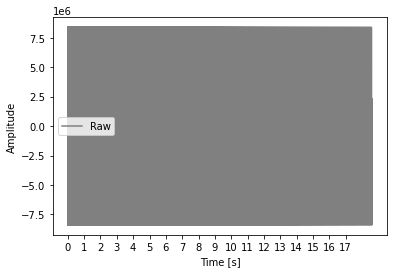

In [178]:
batch_processing(Mode="wav", Raw_csv="./Sony MH750.csv", Target_csv="./Shure SE215.csv", Raw_wav="./BRD.wav",Virtualize=True,xml=True,Limit =2)